<a href="https://colab.research.google.com/github/park-gb/financial-news-sentiment-classifier/blob/main/sentiment_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 구글 드라이브 연동
- "Mounted at /content/drive/"와 같은 출력이 나왔다면 연동 정상

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


:

# 패키지 설치

## Hugging Face 패키지 설치
- 사전 학습 언어모델과 tokenizer를 편리하게 불러올 수 있는 Hugging Face 활용을 위한 패키지를 설치합니다.

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 122.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.9 MB/s eta 0:00:00


## RAdam 패키지 설치
- Optimizer로써 Rectified Adam을 사용할 예정입니다.

In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 12.5 MB/s eta 0:00:00


# 패키지 import

In [ ]:
import os
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import urllib.request
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            roc_auc_score, confusion_matrix, classification_report, \
                            matthews_corrcoef, cohen_kappa_score, log_loss

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# 언어모델 및 Tokenizer 불러오기
- Hugging Face에서 간편하게 Pretrained 언어 모델과 tokenizer를 불러옵니다.
- [KLUE Bert-base 모델](https://huggingface.co/klue/bert-base)을 활용하였습니다.

In [ ]:
MODEL_NAME = "klue/bert-base"
model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3, from_pt=True)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# GPU 작동확인
- GPU는 Colab 상단 메뉴바-Runtime-Change Runtime type-Hardware Accelator 순서대로 접근한 후 선택 가능합니다.

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
  print("GPU 작동 중")
  mirrored_strategy = tf.distribute.MirroredStrategy()
else:
  print("GPU 미작동 중")

GPU 작동 중


# 경제 뉴스 감정 데이터셋 다운로드
- [Github @Ukairia777](https://github.com/ukairia777/finance_sentiment_corpus/blob/main/finance_data.csv) 리포지토리에서 가져옵니다.

In [ ]:
DATASET_URL = "https://raw.githubusercontent.com/ukairia777/finance_sentiment_corpus/main/finance_data.csv"
DATASET_NAME = "finance_data.csv"

In [ ]:
urllib.request.urlretrieve(DATASET_URL,
                           filename = DATASET_NAME
                           )

('finance_data.csv', <http.client.HTTPMessage at 0x7f5cc8140460>)

In [ ]:
dataset = pd.read_csv(DATASET_NAME)
dataset.head()

,labels,sentence,kor_sentence
0,neutral,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,neutral,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,negative,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,positive,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,positive,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


# 데이터 전처리

## 영어 뉴스 기사 칼럼 제거
- 한국어 데이터만 사용할 것이기 때문에 영문 데이터를 포함한 칼럼은 삭제합니다.

In [ ]:
del dataset['sentence']

## 라벨 데이터 숫자 치환

In [ ]:
dataset['labels'] = dataset['labels'].replace(['neutral', 'positive', 'negative'],[0, 1, 2])
dataset.head()

,labels,kor_sentence
0,0,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,2,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,1,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,1,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


## 결측치 확인
- 결측치 미존재

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   labels        4846 non-null   int64 
 1   kor_sentence  4846 non-null   object
dtypes: int64(1), object(1)
memory usage: 75.8+ KB


## 중복 데이터 제거

In [ ]:
# 중복 데이터 확인
dataset[dataset['kor_sentence'].duplicated()]

,labels,kor_sentence
79,1,텔레콤월드와이어-2006년 4월 7일-TJ 그룹은 모닝 디지털 디자인 Oy 핀란드 ...
789,0,그룹의 사업은 스포츠의 광범위한 포트폴리오와 모든 주요 시장에서의 입지에 의해 균형...
1099,0,이 발표 내용에 대한 책임은 전적으로 발행자에게 있습니다.
1394,0,"핀란드 헬싱키에 본사를 둔 레민카이넨 그룹은 토목 공학, 건축 계약, 기술 건축 서..."
1416,0,"이 보고서는 블랙 앤 데커, 피스카스, 피스카스 브랜드, 후스크바르나 아웃도어 프로..."
2396,0,알스트롬의 주가는 나스닥 OMX 헬싱키에서 인용되고 있다.
2567,0,SSH 통신 보안 코퍼레이션은 핀란드 헬싱키에 본사를 두고 있다.
2889,0,재정적인 세부사항은 공개되지 않았다.
2890,0,재정적인 세부사항은 공개되지 않았다.
2892,0,금융 조건은 공개되지 않았다.


In [ ]:
DATASET_PREP_FILE = './data/dataset_prep.csv'
# 중복 데이터 제거
dataset.drop_duplicates(subset = ['kor_sentence'], inplace = True)
#dataset.to_csv(DATASET_PREP_FILE) # 구글 드라이브 내 data 폴더에 저장

# 라벨별 데이터 분포 확인

Text(0, 0.5, 'Number')

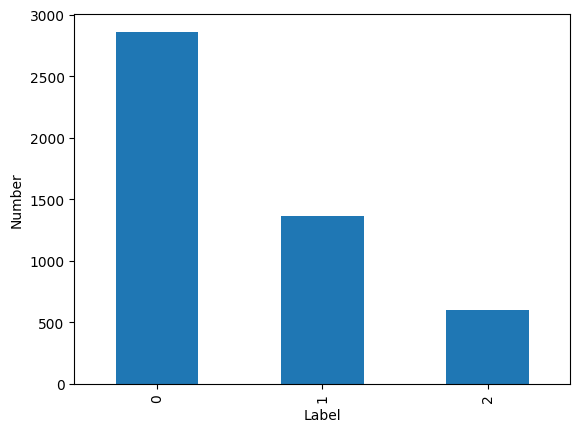

In [ ]:
LABEL_NUM_FILE = './figure/label_number.png'
dataset['labels'].value_counts().plot(kind = 'bar')
plt.xlabel("Label")
plt.ylabel("Number")
#plt.savefig(LABEL_NUM_FILE) # 구글 드라이브 내 figure 폴더에 저장

Text(0, 0.5, 'Ratio')

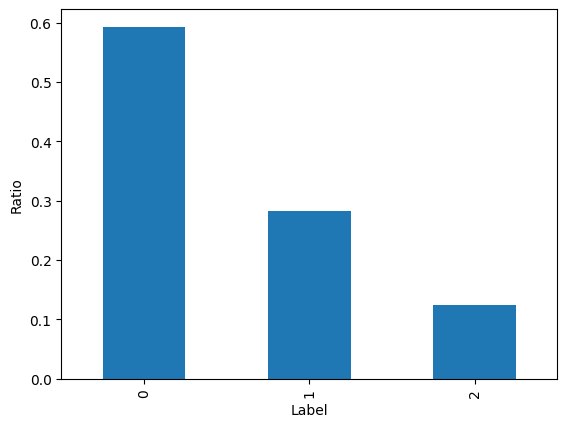

In [ ]:
LABEL_RATIO_FILE = './figure/label_ratio.png'
dataset['labels'].value_counts(normalize = True).plot(kind = 'bar', )
plt.xlabel("Label")
plt.ylabel("Ratio")
#plt.savefig(LABEL_RATIO_FILE)

In [ ]:
# 중립적인 기사문 59.27%, 긍정적인 기사문 28.22%, 부정적인 기사문 12.51%
dataset['labels'].value_counts(normalize = True)

0    0.592708
1    0.282163
2    0.125129
Name: labels, dtype: float64

# Train/Test 데이터 분리

In [ ]:
# 입출력 데이터 분리
X_data = dataset['kor_sentence']
y_data = dataset['labels']

In [ ]:
TEST_SIZE = 0.2 # Train: Test = 8 :2 분리
RANDOM_STATE = 42
# strtify = True 일 경우, 데이터 분리 이전의 라벨별 분포 고려
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = TEST_SIZE,
                                                    random_state = RANDOM_STATE,
                                                    stratify = y_data)

In [ ]:
print(f"훈련 입력 데이터 개수: {len(X_train)}")
print(f"테스트 입력 데이터 개수: {len(X_test)}")

훈련 입력 데이터 개수: 3861
테스트 입력 데이터 개수: 966


In [ ]:
# 훈련 데이터 라벨별 비율
y_train.value_counts(normalize = True)

0    0.592852
1    0.282051
2    0.125097
Name: labels, dtype: float64

In [ ]:
# 테스트 데이터 라벨별 비율
y_test.value_counts(normalize = True)

0    0.592133
1    0.282609
2    0.125259
Name: labels, dtype: float64

# BERT 입력용 데이터 포맷으로 변경

In [ ]:
# 입력 데이터(문장) 길이 제한
MAX_SEQ_LEN = 64

In [ ]:
def convert_data(X_data, y_data):
    # BERT 입력으로 들어가는 token, mask, segment, target 저장용 리스트
    tokens, masks, segments, targets = [], [], [], []

    for X, y in tqdm(zip(X_data, y_data)):
        # token: 입력 문장 토큰화
        token = tokenizer.encode(X, truncation = True, padding = 'max_length', max_length = MAX_SEQ_LEN)

        # Mask: 토큰화한 문장 내 패딩이 아닌 경우 1, 패딩인 경우 0으로 초기화
        num_zeros = token.count(0)
        mask = [1] * (MAX_SEQ_LEN - num_zeros) + [0] * num_zeros

        # segment: 문장 전후관계 구분: 오직 한 문장이므로 모두 0으로 초기화
        segment = [0]*MAX_SEQ_LEN

        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        targets.append(y)

    # numpy array로 저장
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)

    return [tokens, masks, segments], targets

In [ ]:
# train 데이터를 Bert의 Input 타입에 맞게 변환
train_x, train_y = convert_data(X_train, y_train)

3861it [00:07, 515.50it/s]


In [ ]:
# test 데이터를 Bert의 Input 타입에 맞게 변환
test_x, test_y = convert_data(X_test, y_test)

966it [00:02, 391.04it/s]


[array([[    2,  1668,  4308, ...,     0,     0,     0],
        [    2,  4602,  2522, ...,     0,     0,     0],
        [    2,  3701,  2743, ...,     0,     0,     0],
        ...,
        [    2,    12, 13965, ...,    21,    18,     3],
        [    2,  4185,  2078, ...,     0,     0,     0],
        [    2, 14584,  1484, ...,     0,     0,     0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

# BERT를 활용한 파인튜닝

In [ ]:
# token, mask, segment 입력 정의
token_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_word_ids')
mask_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_masks')
segment_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_segment')
bert_outputs = model([token_inputs, mask_inputs, segment_inputs])

In [ ]:
bert_outputs

TFSequenceClassifierOutput(loss=None, logits=<KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'tf_bert_for_sequence_classification')>, hidden_states=None, attentions=None)

In [ ]:
bert_output = bert_outputs[0]

## 감정 분류 모델 컴파일

In [ ]:
DROPOUT_RATE = 0.5
NUM_CLASS = 3
dropout = tf.keras.layers.Dropout(DROPOUT_RATE)(bert_output)
# Multi-class classification 문제이므로 activation function은 softmax로 설정
sentiment_layer = tf.keras.layers.Dense(NUM_CLASS, activation='softmax', kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev=0.02))(dropout)
sentiment_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], sentiment_layer)

In [ ]:
# 옵티마이저 Rectified Adam 하이퍼파리미터 조정
OPTIMIZER_NAME = 'RAdam'
LEARNING_RATE = 5e-5
TOTAL_STEPS = 10000
MIN_LR = 1e-5
WARMUP_PROPORTION = 0.1
EPSILON = 1e-8
CLIPNORM = 1.0
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = LEARNING_RATE,
                                          total_steps = TOTAL_STEPS,
                                          warmup_proportion = WARMUP_PROPORTION,
                                          min_lr = MIN_LR,
                                          epsilon = EPSILON,
                                          clipnorm = CLIPNORM)

In [ ]:
# 감정분류 모델 컴파일
sentiment_model.compile(optimizer = optimizer,
                        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                        metrics = ['accuracy'])

## 조기종료 조건

In [ ]:
MIN_DELTA = 1e-3
PATIENCE = 5

early_stopping = EarlyStopping(
    monitor = "val_accuracy",
    min_delta = MIN_DELTA,
    patience = PATIENCE)

## 최고 성능 모델 저장

In [ ]:
# 최고 성능의 모델 파일을 저장할 이름과 경로 설정
BEST_MODEL_NAME = './model/best_model.h5'

In [ ]:
model_checkpoint = ModelCheckpoint(
    filepath = BEST_MODEL_NAME,
    monitor = "val_loss",
    mode = "min",
    save_best_only = True, # 성능 향상 시에만 모델 저장
    verbose = 1
)

In [ ]:
callbacks = [early_stopping, model_checkpoint]

## 감정 분류 모델 학습

In [ ]:
EPOCHS = 10
BATCH_SIZE = 32

In [ ]:
sentiment_model.fit(train_x, train_y,
                    epochs = EPOCHS,
                    shuffle = True,
                    batch_size = BATCH_SIZE,
                    validation_data = (test_x, test_y),
                    callbacks = callbacks
                    )

Epoch 1/20
121/121 [==============================] - ETA: 0s - loss: 1.0981 - accuracy: 0.3869
Epoch 1: val_loss improved from inf to 1.09413, saving model to ./model/best_model.h5
121/121 [==============================] - 124s 568ms/step - loss: 1.0981 - accuracy: 0.3869 - val_loss: 1.0941 - val_accuracy: 0.6190
Epoch 2/20
121/121 [==============================] - ETA: 0s - loss: 1.0858 - accuracy: 0.5685
Epoch 2: val_loss improved from 1.09413 to 1.07223, saving model to ./model/best_model.h5
121/121 [==============================] - 70s 578ms/step - loss: 1.0858 - accuracy: 0.5685 - val_loss: 1.0722 - val_accuracy: 0.6325
Epoch 3/20
121/121 [==============================] - ETA: 0s - loss: 1.0442 - accuracy: 0.6270
Epoch 3: val_loss improved from 1.07223 to 0.99437, saving model to ./model/best_model.h5
121/121 [==============================] - 70s 578ms/step - loss: 1.0442 - accuracy: 0.6270 - val_loss: 0.9944 - val_accuracy: 0.7516
Epoch 4/20
121/121 [=======================

# 감정 분류의 예측값 계산

In [ ]:
# 최고 성능의 모델 불러오기
sentiment_model_best = tf.keras.models.load_model(BEST_MODEL_NAME,
                                                  custom_objects={'TFBertForSequenceClassification': TFBertForSequenceClassification})

In [ ]:
# 전처리 완료된 데이터 불러오기

test_article = pd.read_csv('/content/drive/MyDrive/기사전처리final(~끝).csv')

In [ ]:
test_article.loc[:, 'contents'] = test_article.loc[:, 'contents'].apply(lambda x: '[CLS] ' + str(x) + ' [SEP]' )

In [ ]:
X_test

759                  예상대로 수요가 활발했고 수주 수준도 높은 수준을 유지하고 있다.
3862    생산은 2009년 초에 피에타르사리에서 시작될 것이고 배송은 2009년 10월에 이...
4721    이 그룹의 주문 포트폴리오는 9~2007년 42.9 mn에서 2~2008년 33.3...
2518                                                순투자수익
1870    StoneGate 제품은 중앙에서 관리할 수 있으며 물리적 환경과 가상 환경 모두에...
                              ...                        
4637            2005년 주당순이익은 2004년 1.15유로에서 0.66유로로 감소했다.
545     중요성: Teleste는 TV 서비스 유통 산업의 급속한 발전뿐만 아니라 큰 규모와...
3808                그 회사는 그 자산을 대차대조표와 재무상태 강화에 사용할 것입니다.
3994         생산수준은 오래전부터 생산자와 합의된 상태여서 소비가 떨어지면 손실로 이어진다.
897     이 회사는 또한 폴란드에서 오보르니키 철골과 샌드위치 패널 공장에서 수익성 프로그램...
Name: kor_sentence, Length: 966, dtype: object

In [ ]:
test_article['contents']

0         "[부동산 개발업체인 육구공이(대표 진상민)가 충북 천안시 청담동 청수법조행정타운 ...
1          내년 4월 준공할 이 상가는 지하 3층~지상 9층에 1~2층은 근린생활, 3층~9...
2                                  대지면적은 838㎡, 연면적은 7097㎡ 다
3         "[[ 김인완 기자  ]                                 ...
4           천안 유수 건설업체인 광천종합건설(주)(대표 조동배)이 시공을 하고, 코리아신탁...
                                ...                        
571584                         1일 단백질 25g과 함께 칼슘 450㎎과 아연 8
571585           또 엄선한 부원료 아미노산혼합제제 3000㎎과 초유 560㎎도 함유되어 있다
571586    이수찬 대표는 "첫 출시한 단백질 제품 외에도 관절, 비타민D, 피로회복과 미백, ...
571587     이어 "앞으로 힘찬닥터스는 건강한 식품을 통해 모든 분들이 장수하고 건강하게 살 ...
571588                                    chan 힘찬닥터스 프로틴']'
Name: contents, Length: 571589, dtype: object

In [ ]:
def convert_data2(X_data):
    # BERT 입력으로 들어가는 token, mask, segment, target 저장용 리스트
    tokens, masks, segments, targets = [], [], [], []

    for X in tqdm(X_data):
        # token: 입력 문장 토큰화
        token = tokenizer.encode(X, truncation = True, padding = 'max_length', max_length = MAX_SEQ_LEN)

        # Mask: 토큰화한 문장 내 패딩이 아닌 경우 1, 패딩인 경우 0으로 초기화
        num_zeros = token.count(0)
        mask = [1] * (MAX_SEQ_LEN - num_zeros) + [0] * num_zeros

        # segment: 문장 전후관계 구분: 오직 한 문장이므로 모두 0으로 초기화
        segment = [0]*MAX_SEQ_LEN

        tokens.append(token)
        masks.append(mask)
        segments.append(segment)

    # numpy array로 저장
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)

    return [tokens, masks, segments]

In [ ]:
test_article_converted = convert_data2(test_article['contents'])

100%|██████████| 571589/571589 [04:26<00:00, 2148.41it/s]


In [ ]:
# 모델이 예측한 라벨 도출
predicted_value = sentiment_model_best.predict(test_article_converted)
predicted_label = np.argmax(predicted_value, axis = 1)

17863/17863 [==============================] - 2587s 145ms/step


In [ ]:
df=pd.DataFrame()

In [ ]:
df['predicted_label']=predicted_label

In [ ]:
df

,predicted_label
0,0
1,0
2,0
3,0
4,0
...,...
571584,0
571585,0
571586,0
571587,1


In [ ]:
df.to_csv('label_0703.csv')

In [ ]:
test_article_converted

[array([[    2, 23591, 22188,     3,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0]]),
 array([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])]

# 감정 분류 모델의 성능 평가

## Classification Report

In [ ]:
# Classification Report 저장
CL_REPORT_FILE = "./metric/cl_report.csv"

cl_report = classification_report(test_y, predicted_label, output_dict = True)
cl_report_df = pd.DataFrame(cl_report).transpose()
cl_report_df = cl_report_df.round(3)
cl_report_df.to_csv(CL_REPORT_FILE)
print(cl_report_df)

OSError: ignored

## Confusion Matrix

In [ ]:
# 이미지 파일 저장정보
# FIGURE_FILE = "./figure/cf_matrix.png"

cf_matrix = confusion_matrix(test_y, predicted_label)
fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(cf_matrix, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('Predicted')
# plt.savefig(FIGURE_FILE)
plt.show()

## 전체 평가지표

In [ ]:
# Multi-class Classification의 대중적인 평가 지표 모두 확인
accuracy_score_v = round(accuracy_score(y_test, predicted_label), 3) # Accuracy
precision_score_v = round(precision_score(y_test, predicted_label, average="weighted"), 3) # Precision
recall_score_v = round(recall_score(y_test, predicted_label, average="weighted"), 3) # Recall
f1_score_v = round(f1_score(y_test, predicted_label, average="weighted"), 3) # F1 Score
roc_auc_score_v = round(roc_auc_score(y_test, predicted_value, average="weighted", multi_class="ovr"), 3) # ROC AUC Score
cohen_kappa_score_v = round(cohen_kappa_score(y_test, predicted_label), 3) # Cohen's Kappa Score
matthews_corrcoef_v = round(matthews_corrcoef(y_test, predicted_label), 3) # Matthew's Correlation Coefficient
log_loss_v = round(log_loss(y_test, predicted_value), 3) # Log Loss

In [ ]:
#METRIC_FILE = './metric/metric.csv'

In [ ]:
# 평가지표 결과 저장
metric_total = pd.DataFrame({
    'PLM': MODEL_NAME,
    'Optimizer': OPTIMIZER_NAME,
    'Accuracy': accuracy_score_v,
    'Precision': precision_score_v,
    'Recall': recall_score_v,
    'F1_score': f1_score_v,
    'ROC_AUC_score': roc_auc_score_v,
    'Cohen_kappa_coef': cohen_kappa_score_v,
    'Matthews_corrcoef': matthews_corrcoef_v,
    'Log_loss': log_loss_v},
    index = ['-']
    )

In [ ]:
# metric_total.to_csv(METRIC_FILE)

In [ ]:
print(metric_total)